In [2]:
from numpy.random import seed
seed(8)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, model_selection


def read_split_data(iris_data):
    data = iris_data['data']
    targets = iris_data['target']
    train_data,test_data,train_targets,test_targets = model_selection.train_test_split(data,targets,test_size=0.1)
    return (train_data,test_data,train_targets,test_targets)


iris_dataset = datasets.load_iris()
train_data,test_data,train_targets,test_targets=read_split_data(iris_dataset)


2023-06-03 19:13:12.625178: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 19:13:13.513207: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
train_targets = tf.keras.utils.to_categorical(train_targets)
test_targets = tf.keras.utils.to_categorical(test_targets)

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model(input_shape):
    model = Sequential([
        Dense(64,activation='relu',input_shape=(input_shape),kernel_initializer=tf.keras.initializers.HeUniform(),bias_initializer=tf.keras.initializers.Constant(value=1)),
        Dense(128,activation='relu'),
        Dense(128,activation='relu'),
        Dense(128,activation='relu'),
        Dense(128,activation='relu'),
        Dense(64,activation='relu'),
        Dense(64,activation='relu'),
        Dense(64,activation='relu'),
        Dense(64,activation='relu'),
        Dense(3,activation='softmax')
    ])
    return model

In [5]:
model = get_model(train_data[0].shape)

2023-06-03 19:13:15.527558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-03 19:13:15.569844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-03 19:13:15.570132: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
def compile_model(model):
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss = tf.keras.losses.CategoricalCrossentropy()
    acc = tf.keras.metrics.Accuracy()
    model.compile(optimizer=opt,loss=loss,metrics=['accuracy'])

In [7]:
compile_model(model)

In [8]:
def train_model(model,train_data,train_targets,epoch):
    history = model.fit(train_data,train_targets,validation_split=0.15,epochs=epoch,verbose=False)
    return history

In [9]:
history = train_model(model,train_data,train_targets,epoch=800)

2023-06-03 19:13:18.772430: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f526c00dbc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-03 19:13:18.772464: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2023-06-03 19:13:18.778665: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-03 19:13:18.997426: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-03 19:13:19.148055: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


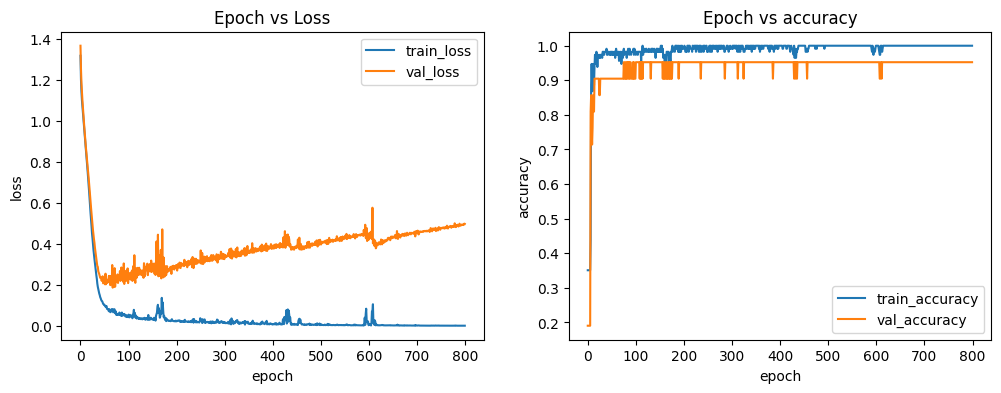

In [10]:
import pandas as pd

def plot_history(history):
    result_df = pd.DataFrame(history.history)
    epoch_arr = np.arange(len(result_df))
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(121)
    ax.plot(epoch_arr,result_df['loss'],label="train_loss")
    ax.plot(epoch_arr,result_df['val_loss'],label="val_loss")
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.set_title("Epoch vs Loss")
    ax.legend()


    ax = fig.add_subplot(122)
    ax.plot(epoch_arr,result_df['accuracy'],label="train_accuracy")
    ax.plot(epoch_arr,result_df['val_accuracy'],label="val_accuracy")
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")
    ax.set_title("Epoch vs accuracy")
    ax.legend()

plot_history(history)

In [11]:
def get_regularised_model(input_shape,dropout_rate,weight_decay):
    model = Sequential([
        Dense(64,activation='relu',input_shape=(input_shape),
              kernel_initializer=tf.keras.initializers.HeUniform(),
              bias_initializer=tf.keras.initializers.Constant(value=1),
              kernel_regularizer=tf.keras.regularizers.L2(weight_decay)),
        Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(weight_decay)),
        Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(weight_decay)),
        tf.keras.layers.Dropout(dropout_rate),
        Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(weight_decay)),
        Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(weight_decay)),
        tf.keras.layers.BatchNormalization(),
        Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(weight_decay)),
        Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(weight_decay)),
        tf.keras.layers.Dropout(dropout_rate),
        Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(weight_decay)),
        Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(weight_decay)),
        Dense(3,activation='softmax')
    ])
    return model

In [12]:
reg_model = get_regularised_model(train_data[0].shape,0.3,0.001)

In [13]:
compile_model(reg_model)

In [14]:
reg_history = train_model(reg_model,train_data,train_targets, epoch=800)

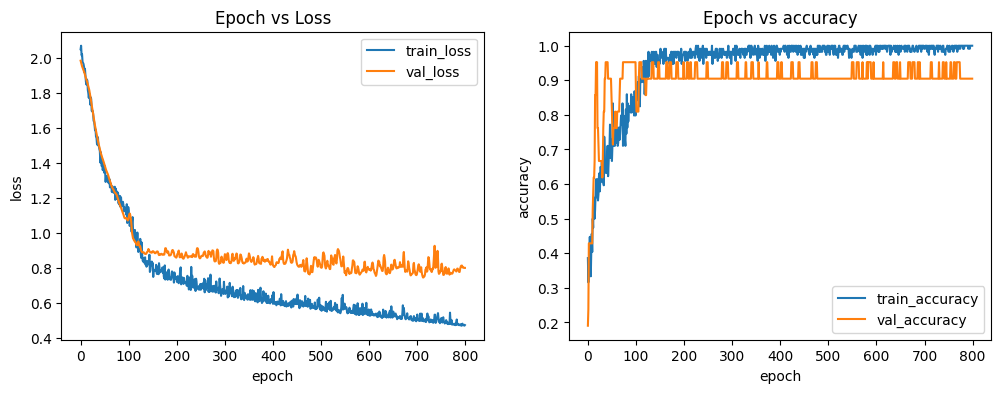

In [15]:
plot_history(reg_history)

In [ ]:
def get_callbacks():
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=30,mode='min')
    lr_rate = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2,patience=20)
    return early_stopping,lr_rate
    